In [1]:
import sklearn.model_selection
from sklearn.datasets import fetch_openml
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import numpy as np

X, y = fetch_openml(data_id=40691, as_frame=True, return_X_y=True)
y = np.array(y, dtype=int)

/root/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
# !ln -s /usr/local/bin/pip /usr/bin/pip3.8
# !pip install --user imblearn

In [3]:
import autosklearn
from autosklearn.classification import AutoSklearnClassifier
import imblearn

In [4]:
from pprint import pprint

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Problem statement

From the auto-sklearn fail assignment and the pipe line optimization assignment, we have observed that the random forest (RF) classifier performs quite well on the dataset even with the default parameter. It took many approaches to further improve the performance of the tuned RF classifier. How the performance was improved and by how much each changes bring to the model performance is not clear. In this assignment, we will conduct an ablation study to understand the impact of each hyperparameter tuning on the performance of the RF classifier. We will use the `RandomForestClassifier` from the `sklearn` library to perform the hyperparameter tuning. By default, auto-sklearn uses Bayesian Optimization to perform the hyperparameter tuning. We will use the `accuracy` as the performance metric to evaluate the model performance.

# Dataset

Since I am using the same dataset as the previous assignment, the issue of the data is the same. The dataset is imbalanced and features are skewed. Therefore, I will put SMOTE and scaler optimization into the ablation study.

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
dtypes: float64(11)
memory usage: 137.5 KB


In [7]:
X.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


# Ablation study

The ablation study for the random forest will be focused on comparing the autosklearn tuned pipeline performance vs. 
the default model only performance. This ablation study will reveal the impact of each hyperparameter tuning on the performance of the RF classifier. The hyperparameters that will be tuned are as follows:

- SMOTE
- Scaler
- total search time
- resampling strategy and arguments
- n_estimators
- max_depth
- min_samples_split
- min_samples_leaf
- max_features
- bootstrap
- criterion
- max_samples

In [12]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

In [13]:
# X_samp, y_samp = SMOTETomek(random_state=42, sampling_strategy='auto').fit_resample(X, y)
samp_count = {
    3: 200,
    4: 200,
#     5: 200,
#     6: 200,
#     7: 200,
    8: 200
}
X_samp, y_samp = SMOTETomek(random_state=42, sampling_strategy=samp_count).fit_resample(X, y)

In [14]:
list(zip(*np.unique(y, return_counts=True)))

[(3, 10), (4, 53), (5, 681), (6, 638), (7, 199), (8, 18)]

In [15]:
list(zip(*np.unique(y_samp, return_counts=True)))

[(3, 197), (4, 181), (5, 599), (6, 546), (7, 167), (8, 188)]

In [16]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_samp, y_samp, random_state=0, train_size=0.7)

In [17]:
# rb = RobustScaler().fit(X_train)
# X_train_trans = rb.transform(X_train)
# X_test_trans = rb.transform(X_test)

In [18]:
clf = RandomForestClassifier(random_state=42)
clf = clf.fit(X_train, y_train)
default_score = clf.score(X_test, y_test)
print("Default RF Accuracy", default_score)

Default RF Accuracy 0.75


In [61]:
scorer = autosklearn.metrics.accuracy
automl = AutoSklearnClassifier(time_left_for_this_task=1200,
                               per_run_time_limit=100,
                               n_jobs=5,
                               seed=42,
                              include = {
                                            'classifier': ["random_forest"],
                                            # 'feature_preprocessor': ["no_preprocessing"]
                                        },
                               resampling_strategy="cv",
                               resampling_strategy_arguments={"train_size": 0.7,     # The size of the training set
                                                                "shuffle": True,        # Whether to shuffle before splitting data
                                                                "folds": 3    },
                               metric=scorer
                              )
automl.fit(X_train, y_train)
# y_hat = automl.predict(X_test_trans)
print("AutoML Accuracy", automl.score(X_test, y_test))

[WARNING] [2024-04-28 00:35:26,420:Client-AutoMLSMBO(42)::32c9a1b1-04f7-11ef-9362-0242ac110002] Configuration 129 not found
[WARNING] [2024-04-28 00:35:26,424:Client-AutoMLSMBO(42)::32c9a1b1-04f7-11ef-9362-0242ac110002] Configuration 595 not found
[WARNING] [2024-04-28 00:35:26,425:Client-AutoMLSMBO(42)::32c9a1b1-04f7-11ef-9362-0242ac110002] Configuration 608 not found
[WARNING] [2024-04-28 00:35:26,426:Client-AutoMLSMBO(42)::32c9a1b1-04f7-11ef-9362-0242ac110002] Configuration 83 not found
[WARNING] [2024-04-28 00:35:26,426:Client-AutoMLSMBO(42)::32c9a1b1-04f7-11ef-9362-0242ac110002] Configuration 124 not found
[WARNING] [2024-04-28 00:35:26,428:Client-AutoMLSMBO(42)::32c9a1b1-04f7-11ef-9362-0242ac110002] Configuration 434 not found
[WARNING] [2024-04-28 00:35:26,428:Client-AutoMLSMBO(42)::32c9a1b1-04f7-11ef-9362-0242ac110002] Configuration 683 not found
[WARNING] [2024-04-28 00:35:26,428:Client-AutoMLSMBO(42)::32c9a1b1-04f7-11ef-9362-0242ac110002] Configuration 352 not found
[WARNING]

AutoML Accuracy 0.7553191489361702


In [62]:
print(automl.leaderboard())

          rank  ensemble_weight           type      cost   duration
model_id                                                           
41           1             0.12  random_forest  0.250381  52.741691
49           2             0.08  random_forest  0.260274  72.780458
7            3             0.04  random_forest  0.262557  23.732624
50           4             0.06  random_forest  0.265601  35.486047
84           5             0.06  random_forest  0.265601  87.699641
65           6             0.02  random_forest  0.267123  87.939051
21           7             0.08  random_forest  0.268645  32.508962
69           8             0.02  random_forest  0.273973  45.950902
4            9             0.14  random_forest  0.275495  63.576401
3           10             0.02  random_forest  0.283105  36.530644
33          11             0.08  random_forest  0.292237  35.023689
38          13             0.02  random_forest  0.295282  42.332985
78          12             0.06  random_forest  

In [65]:
automl.show_models()[41]

{'model_id': 41,
 'rank': 10,
 'cost': 0.2503805175038052,
 'ensemble_weight': 0.12,
 'voting_model': VotingClassifier(estimators=None, voting='soft'),
 'estimators': [{'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x416badfc10>,
   'balancing': Balancing(random_state=42, strategy='weighting'),
   'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x410139c370>,
   'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x4159b68400>,
   'sklearn_classifier': RandomForestClassifier(bootstrap=False, max_features=2, min_samples_split=6,
                          n_estimators=512, n_jobs=1, random_state=42,
                          warm_start=True)},
  {'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x40ffc5fc10>,
   'balancing': Balancing(random_state=42, strategy='weighting'),
   'feature_preprocessor

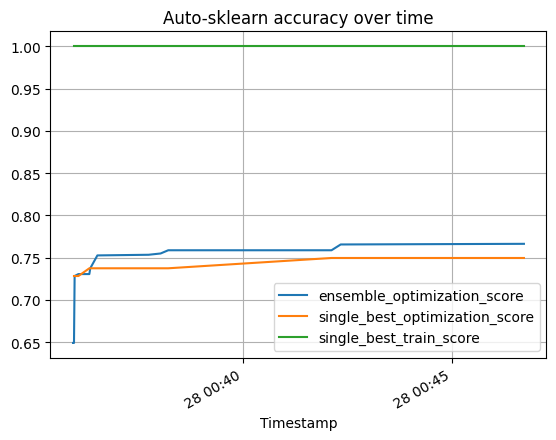

In [67]:
poT = automl.performance_over_time_
poT.plot(
    x="Timestamp",
    kind="line",
    legend=True,
    title="Auto-sklearn accuracy over time",
    grid=True,
)
plt.show()

In [68]:
losses_and_configurations = [
    (run_value.cost, run_key.config_id)
    for run_key, run_value in automl.automl_.runhistory_.data.items()
]
losses_and_configurations.sort()
print("Lowest loss:", losses_and_configurations[0][0])
print(
    "Best configuration:",
    automl.automl_.runhistory_.ids_config[losses_and_configurations[0][1]],
)

Lowest loss: 0.2503805175038052
Best configuration: Configuration(values={
  'balancing:strategy': 'weighting',
  'classifier:__choice__': 'random_forest',
  'classifier:random_forest:bootstrap': 'False',
  'classifier:random_forest:criterion': 'gini',
  'classifier:random_forest:max_depth': 'None',
  'classifier:random_forest:max_features': 0.3211037518766139,
  'classifier:random_forest:max_leaf_nodes': 'None',
  'classifier:random_forest:min_impurity_decrease': 0.0,
  'classifier:random_forest:min_samples_leaf': 1,
  'classifier:random_forest:min_samples_split': 6,
  'classifier:random_forest:min_weight_fraction_leaf': 0.0,
  'data_preprocessor:__choice__': 'feature_type',
  'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'mean',
  'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'standardize',
  'feature_preprocessor:__choice__': 'fast_ica',
  'feature_preprocessor:fast_ica:algorithm': 'deflation',
  'feature_preprocessor:fast

# Ablation Study with the pipeline

The ablation study will be conducted with a greedy approach -- we will start with the default model and add hyperparameters one by one based on the performance improvement of that hyperparameter. We use the best tuned random forest model (ie., the highest-rank RF by AutoML). First we need to find the highest performance improvement over the default hyperparameters.


| Pipeline | Default | Tuned |
| ---- | ---- | ---- |
| Accuracy | 0.75 | 0.7553 |
| **Data preprocessor** | None | StandardScaler |
| **Feature preprocessor** | None | fast_ica |
| **bootstrap** | True | False |
| criterion | gini | gini |
| max_depth | None | None |
| **max_features** | 'sqrt' |  0.3211037518766139 |
| max_leaf_nodes | None | None |
| min_impurity_decrease | 0.0 | 0.0 |
| min_samples_leaf | 1 | 1 |
| **min_samples_split** | 2 | 6 |
| min_weight_fraction_leaf | 0.0 | 0.0 |
| n_estimators | 100 | 100 |
| warm_start | False | False |

From the table above, we can observe that only `Data preprocessor`, `Feature preprocessor`, `bootstrap`, `max_features`, and `min_samples_split` have changed for the tuned RF classifier compared to the default RF classifier. The rest of the hyperparameters have remained the same. Therefore, we will only focus on ablation study of these changed hyperparameters


In [69]:
from copy import deepcopy
from sklearn.pipeline import Pipeline

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA

In [71]:
data_prep = StandardScaler()
feat_prep = FastICA(algorithm='deflation', fun='logcosh', whiten=False, random_state=42)

In [79]:
final_params = [
    ("scaler", data_prep), ("transform", feat_prep),
    {"bootstrap": False}, {"max_features": 0.3211037518766139},
    {"min_samples_split": 6}, 
    #{"n_estimators": 512}, {"warm_start": True}
]

In [80]:
order_score = [(default_score, None)]
tuned = {
    "prep": [],
    "model": {}
}
to_tune = deepcopy(final_params) 
while len(to_tune) > 0:
    cur_score = 0
    cur_param = None
    tune_candidate = None
    for param in to_tune:
        cur_tune = deepcopy(tuned)
        if isinstance(param, dict):
            # print(param)
            cur_tune['model'].update(param)
        else:
            cur_tune['prep'].append(param)
        pipe = Pipeline([*cur_tune['prep'], ("rf", RandomForestClassifier(**cur_tune['model'], random_state=42))])
        pipe.fit(X_train, y_train)
        score = pipe.score(X_test, y_test)
        if score > cur_score:
            cur_score = score
            cur_param = param
            tune_candidate = cur_tune
        print(score, param)
    print("Best score", cur_score, "with", cur_param)
    order_score.append((cur_score, cur_param))
    to_tune.remove(cur_param)
    tuned = tune_candidate

0.7464539007092199 ('scaler', StandardScaler())
0.7464539007092199 ('transform', FastICA(algorithm='deflation', random_state=42, whiten=False))
0.7340425531914894 {'bootstrap': False}
0.75 {'max_features': 0.3211037518766139}
0.7393617021276596 {'min_samples_split': 6}
Best score 0.75 with {'max_features': 0.3211037518766139}
0.7464539007092199 ('scaler', StandardScaler())
0.7464539007092199 ('transform', FastICA(algorithm='deflation', random_state=42, whiten=False))
0.7340425531914894 {'bootstrap': False}
0.7393617021276596 {'min_samples_split': 6}
Best score 0.7464539007092199 with ('scaler', StandardScaler())
0.7446808510638298 ('transform', FastICA(algorithm='deflation', random_state=42, whiten=False))
0.7340425531914894 {'bootstrap': False}
0.7393617021276596 {'min_samples_split': 6}
Best score 0.7446808510638298 with ('transform', FastICA(algorithm='deflation', random_state=42, whiten=False))
0.7624113475177305 {'bootstrap': False}
0.7429078014184397 {'min_samples_split': 6}
Best

In [81]:
from pprint import pprint

In [82]:
pprint(order_score)
scores, params = list(zip(*order_score))
scores = np.array(scores)
print("Improvement:")
pprint((scores[1:] - scores[:-1]) / scores[:-1])

[(0.75, None),
 (0.75, {'max_features': 0.3211037518766139}),
 (0.7464539007092199, ('scaler', StandardScaler())),
 (0.7446808510638298,
  ('transform', FastICA(algorithm='deflation', random_state=42, whiten=False))),
 (0.7624113475177305, {'bootstrap': False}),
 (0.7553191489361702, {'min_samples_split': 6})]
Improvement:
array([ 0.        , -0.00472813, -0.0023753 ,  0.02380952, -0.00930233])


In [84]:
pipe = Pipeline([('transform', feat_prep),
                 ('scaler', data_prep),
                 ("rf", RandomForestClassifier(**{'max_features': 0.3211037518766139,
                                                 'bootstrap': False},
                                               random_state=42))])
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print(score)

0.7641843971631206


# Results and Discussion

| Componenets | performance (accuracy) | percentage Improvement |
| ---- | ---- | ---- |
| max_features | 0.75 | 0% |
| scaler | 0.7465 | -0.473% |
| transform | 0.7447 | -0.238% |
| bootstrap | 0.7624 | +2.38% |
| min_samples_split | 0.7553 | -0.930% |

The ablation study above shows some interesting results. With a greedy approach to study ablation path, we always pick hyperparameter one-by-one based on its impact on the overall the accuracy score of the model for the current state. The tuned pipeline has the highest performance improvement after disabling `bootstrap`. The pipeline's performance decreased slightly for other hyperparameter changes. The model can achieve a better performance if `min_samples_split` remained the same as default.

It is interesting that many HPs for the tuned RF classifier are the same as the default model. I think this is likely due to the default RF hyperparameters are almost an optimal set for RF classifier for this dataset. This also explains in many cases that RF can be a good first-choice for certain task or acts as a surrogate model during HPO process.